In this kernel we will try to denoise dirty documents using autoencoders.Autoencoders are neural networks composed of an encoder and a decoder.

The encoder compresses the input data into a lower-dimensional representation. The decoder reconstructs the representation to obtain an output that mimics the input as closely as possible. In doing so, the autoencoder learns the most salient features of the input data.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from skimage import io
from  tqdm.notebook import tqdm as tqdm_notebook
import os
from tensorflow.keras import Input
import albumentations
from albumentations import (
    HorizontalFlip,Flip,VerticalFlip,Rotate,Compose)
from tensorflow.python.keras.utils.data_utils import Sequence
import cv2
import matplotlib.pyplot as plt
import math
import random

In [5]:
if not os.path.exists('/kaggle/working/data'):
    os.mkdir('/kaggle/working/data')
    
zip_path = '/kaggle/input/denoising-dirty-documents/train_cleaned.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data')
    
zip_path = '/kaggle/input/denoising-dirty-documents/train.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data')
    
zip_path = '/kaggle/input/denoising-dirty-documents/test.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data')
    
train_dir = '/kaggle/working/data/train'
train_clean_dir = '/kaggle/working/data/train_cleaned'
test_dir = '/kaggle/working/data/test'


In [4]:
#loading data
def load_images(folder_path):
    images = [image for image in os.listdir(folder_path)]

    image_arr = np.zeros((len(images),258,540,1))  #height,width
    for i in tqdm_notebook(range(len(images)),total=len(images)):
        img = cv2.imread(os.path.join(folder_path,images[i]),0) 
        img = cv2.resize(img, (540,258))  #width,height      
        img = img/255.0
        img = np.expand_dims(img, axis=-1).astype('float32')
        image_arr[i] = img
        
    return image_arr    

In [4]:
train_images = load_images(train_dir)
test_images = load_images(test_dir)
train_clean_images = load_images(train_clean_dir)

## Augmentations for increasing training data

In [5]:
flip_hor = Compose([
                HorizontalFlip(p=1)    
                    ])

flip_vert = Compose([
                VerticalFlip(p=1)      
                    ])

def prepare_data(images,masks,horizontal_flip=True,vertical_flip=True):
    final_images,final_masks= [],[]
    flip_idx1 = np.random.choice(np.arange(0,len(images)), 80, replace=False)
    flip_idx2 = np.random.choice(np.arange(0,len(images)), 80, replace=False)
    for i in range(len(images)):
            final_images.append(images[i])
            final_masks.append(masks[i])
            if horizontal_flip:
                if i in flip_idx1:
                    augmented = flip_hor(image=images[i],mask=masks[i])
                    final_images.append(augmented['image'])
                    final_masks.append(augmented['mask'])
            if vertical_flip:
                if i in flip_idx2:
                    augmented = flip_vert(image=images[i],mask=masks[i])
                    final_images.append(augmented['image'])
                    final_masks.append(augmented['mask'])

    return np.array(final_images),np.array(final_masks)
               

In [6]:
train_images,train_clean_images = prepare_data(train_images,train_clean_images)

## Splitting to train and Validation

In [7]:
def train_val_split(x_data,y_data,split_ratio=0.8):
        indices = np.arange(x_data.shape[0])
        np.random.shuffle(indices)
        x_data = x_data[indices]
        y_data = y_data[indices]
        split_num = int(0.8 * len(x_data))
        x_train,y_train = x_data[:split_num],y_data[:split_num]
        x_val,y_val = x_data[split_num:],y_data[split_num:]
        return x_train,y_train,x_val,y_val

In [8]:
X_train,y_train,X_val,y_val = train_val_split(train_images,train_clean_images)


In [9]:
print('Number of train input images {}'.format(X_train.shape[0]))
print('Number of validation input images {}'.format(X_val.shape[0]))

Number of train input images 243
Number of validation input images 61


## Visulaization

In [10]:
def plot_img(no,x_data,y_data):
    fig, axes = plt.subplots(5, 2,figsize=(20,20))
    for i in range(no):
        axes[i,0].imshow(x_data[i].squeeze(),cmap='gray')
        axes[i,0].set_title('images-noisy')
        axes[i,1].imshow(y_data[i].squeeze(),cmap='gray') 
        axes[i,1].set_title('images-cleaned')
    fig.tight_layout() 

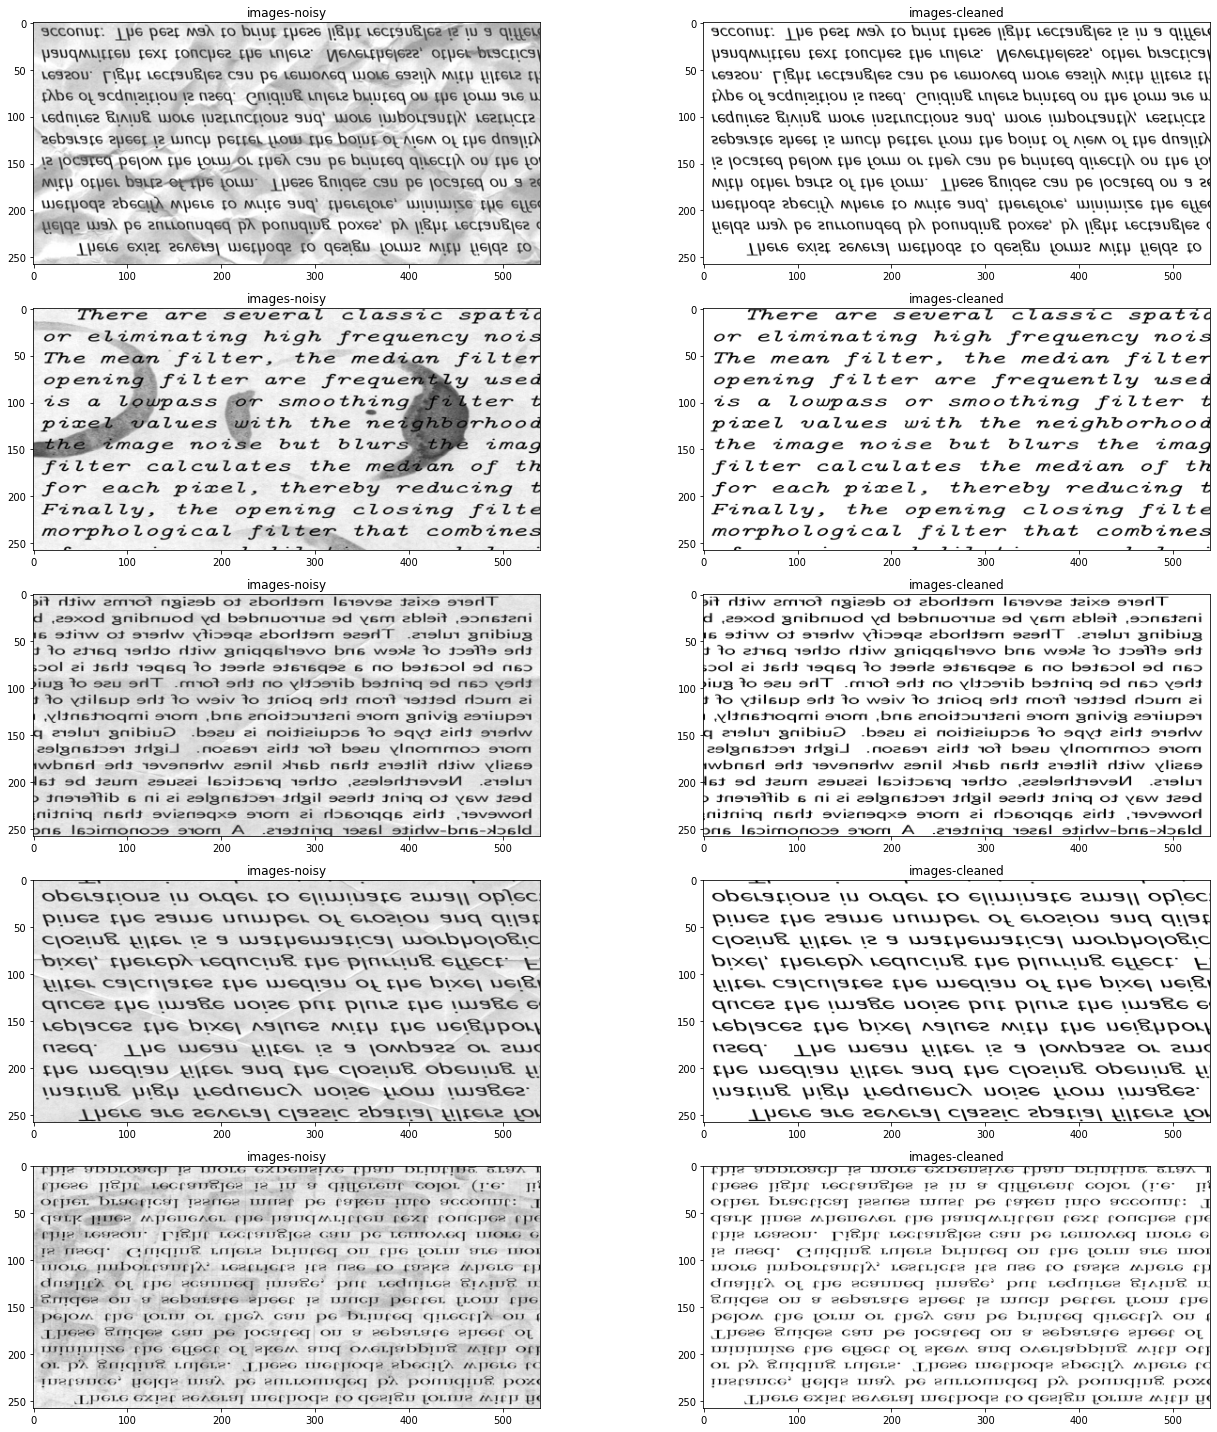

In [11]:
plot_img(5,X_train,y_train)

## Loading the Data

In [12]:
def auto_encoder(img_shape):
    input_layer = Input(shape=img_shape)
    # encoder
    conv1 = Conv2D(filters=64, kernel_size=(3,3),activation='relu',padding='same')(input_layer)
    conv2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(conv1)
    h = MaxPooling2D((2, 2), padding='same')(conv2)
    #decoder
    h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    h = UpSampling2D((2, 2))(h)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)    
    return keras.Model(input_layer, output_layer)


In [13]:
optimizer = Adam(lr=0.001)
model = auto_encoder(train_images[0].shape)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 540, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 258, 540, 1)       577   

In [14]:
epochs = 100
batch_size = 10
save_point = '/kaggle/working/chkpoint'

if not os.path.exists(save_point):
    os.mkdir(save_point)

early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')

mcp_save = ModelCheckpoint(save_point+'/mdl.hdf5', save_best_only=True, 
                           monitor='val_loss', mode='min')
history = model.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping,mcp_save])

Train on 243 samples, validate on 61 samples
Epoch 1/100
243/243 [==============================] - 8s 33ms/sample - loss: 0.0912 - val_loss: 0.0779
Epoch 2/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0642 - val_loss: 0.0524
Epoch 3/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0372 - val_loss: 0.0238
Epoch 4/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0207 - val_loss: 0.0162
Epoch 5/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0149 - val_loss: 0.0124
Epoch 6/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0112 - val_loss: 0.0101
Epoch 7/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0089 - val_loss: 0.0076
Epoch 8/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0073 - val_loss: 0.0066
Epoch 9/100
243/243 [==============================] - 3s 12ms/sample - loss: 0.0063 - val_loss: 0.0058
Epoch 10/100
243/24

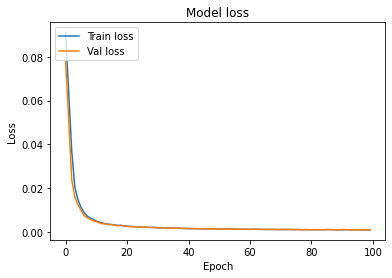

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.show()


In [16]:
#loading the model
model = load_model('chkpoint/mdl.hdf5')

In [17]:
# function for loading the image
def eval_model(test_images):
    preds = model.predict(test_images)
    return preds

preds = eval_model(test_images)
preds_denormalized  = np.array([(i*255.0) for i in preds])
preds_denormalized.shape

(72, 258, 540, 1)

## visualizing predicted images

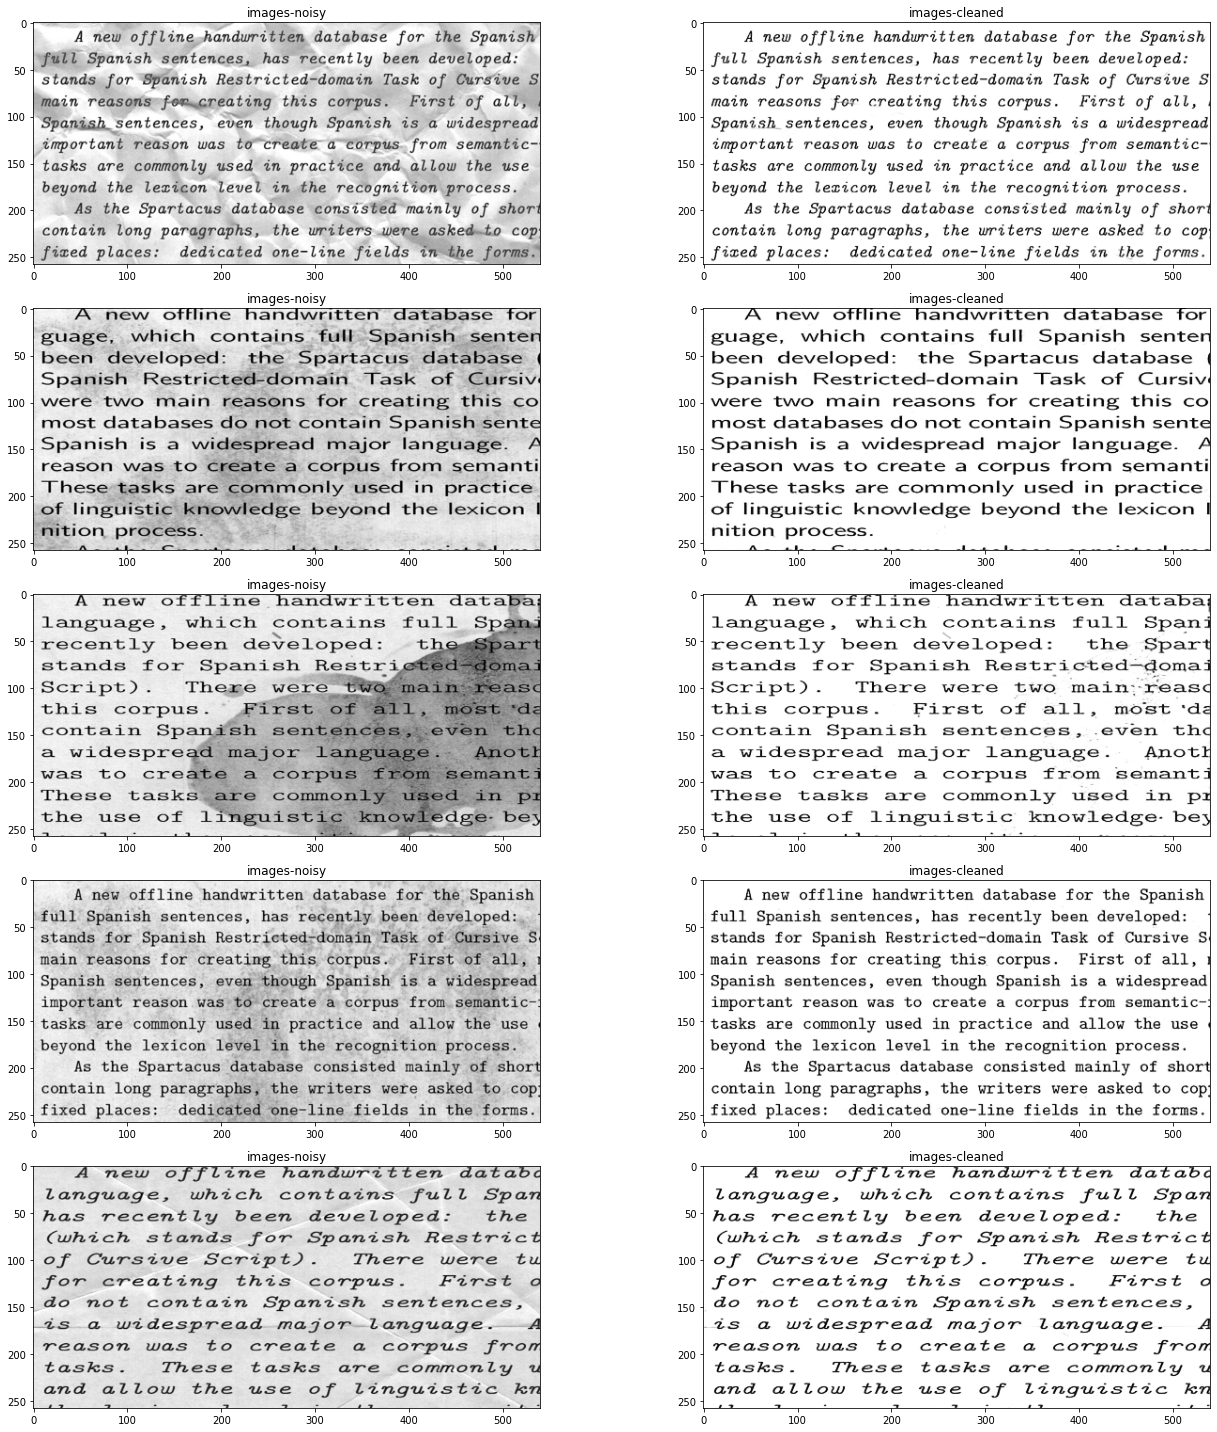

In [18]:
plot_img(5,test_images,preds_denormalized)